<a href="https://colab.research.google.com/github/Molzard/PCVK-Ganjil-2025/blob/main/Week14_Kelompok_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Kelompok 4**
1. Alfaro Van Mats
2. Melany Eka Suci Dewinta Sari
3. Putri Shaqinah Azelea


# **Download dataset melalui kaggle**

Mengunduh dataset Fruits-360 dari Kaggle secara otomatis.
Kode mengambil API key Colab, lalu menjalankan perintah download .zip.

In [ ]:
from google.colab import userdata
import os

try:
  os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
  os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
except Exception as e:
  print(e)

!kaggle datasets download -d moltean/fruits

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
100% 4.75G/4.76G [00:57<00:00, 256MB/s]
100% 4.76G/4.76G [00:57<00:00, 89.2MB/s]


# **Extract dataset**

File fruits.zip diekstrak ke folder baru menggunakan modul zipfile.
Digunakan tqdm untuk progress bar selama ekstraksi.

In [ ]:
import zipfile
from tqdm import tqdm

zip_path = "fruits.zip"
extract_path = "fruits360"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    total_files = len(zip_ref.infolist())
    with tqdm(total=total_files, desc='Extracting') as pbar:
        for file in zip_ref.infolist():
            zip_ref.extract(file, extract_path)
            pbar.update(1)


Extracting: 100%|██████████| 290577/290577 [01:54<00:00, 2531.57it/s]


# **Proses Pra Pengolahan Data & Labeling**

## **Remapped Training**

Membuat kamus (dictionary) class_map untuk menggabungkan banyak nama folder berbeda menjadi 19 kelas final.

In [ ]:
import os
import shutil

# Mapping class (19)

class_map = {
    # Beetroot
    "Beetroot 1": "Beetroot_Red",

    # Cabbage
    "Cabbage red 1" : "Cabbage",
    "Cabbage white 1" : "Cabbage",

    # Carrot
    "Carrot 1" : "Carrot",

    # Cauliflower
    "Cauliflower 1" : "Cauliflower",

    # Ginger Root
    "Ginger Root 1" : "Ginger Root",

    # Kohlrabi
    "Kohlrabi 1" : "Kohlrabi",

    # Onion
    "Onion Red 1" : "Onion_Red",
    "Onion Red Peeled 1" : "Onion_Red",
    "Onion Red 2" : "Onion_Red",
    "Onion White 1" : "Onion_White",
    "Onion White Peeled 1" : "Onion_White",
    "Onion 2" : "Onion",

    # Potato
    "Potato Red 1" : "Potato_Red",
    "Potato Red Washed 1" : "Potato_Red",
    "Potato White 1" : "Potato_White",
    "Potato Sweet 1" : "Potato_Sweet",

    # Granadilla
    "Granadilla 1" : "Granadilla",

    # Maracuja
    "Maracuja 1" : "Maracuja",

    # Passion fruit
    "Passion Fruit 1" : "Passion_Fruit",

    # Plum
    "Plum 1" : "Plum_1",
    "Plum 2" : "Plum_2",
    "Plum 3" : "Plum_3",

    # Watermelon
    "Watermelon 1" : "Watermelon",
}

# Remap Test dataset

source_test = "/content/fruits360/fruits-360_100x100/fruits-360/Training"
target_test = "/content/Remapped_Training"

os.makedirs(target_test, exist_ok=True)

for original_class, new_class in class_map.items():

    src_dir = os.path.join(source_test, original_class)
    dst_dir = os.path.join(target_test, new_class)

    if not os.path.isdir(src_dir):
        print(f"[SKIP] Tidak ditemukan: {src_dir}")
        continue

    os.makedirs(dst_dir, exist_ok=True)

    for file in os.listdir(src_dir):
        src = os.path.join(src_dir, file)
        dst = os.path.join(dst_dir, f"{original_class}_{file}")
        shutil.copy2(src, dst)

print("Selesai! Remapped_Training berhasil dibuat.")

Selesai! Remapped_Training berhasil dibuat.


Memindai isi folder Remapped_Training, lalu membuat file label_final.json berisi:

- path gambar

- label kelas

Total citra yang tersimpan: 11087.

In [ ]:
import os, json, shutil, cv2, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from sklearn.preprocessing import LabelEncoder

# Membuat labeling final yang disimpan ke file .json

DATASET_ROOT = "/content/Remapped_Training"
LABEL_PATH = "/content/label_final.json"

def build_label_json(root):
    data = []
    for cls in tqdm(os.listdir(root), desc="Scanning"):
        cls_path = os.path.join(root, cls)
        if not os.path.isdir(cls_path):
            continue
        for img in os.listdir(cls_path):
            if img.lower().endswith(('.png','.jpg','.jpeg')):
                data.append({
                    "path": os.path.join(cls_path, img),
                    "label": cls
                })
    with open(LABEL_PATH, 'w') as f:
        json.dump(data, f, indent=2)
    print(f"label_final.json tersimpan: {len(data)} citra")

build_label_json(DATASET_ROOT)

Scanning: 100%|██████████| 19/19 [00:00<00:00, 732.31it/s]

label_final.json tersimpan: 11007 citra


Validasi Konsistensi Tabel (Cek Duplikasi dan Distribusi)

Mengecek:

- Apakah ada path gambar duplikat? → Hasil: Tidak ada.

- Ada berapa label unik? → 19 kelas

- Distribusi jumlah gambar tiap kelas

Ini memastikan file label_final.json benar sebelum preprocessing.

In [ ]:
# Validasi Konsisten Tabel

import collections
with open(LABEL_PATH) as f:
    records = json.load(f)

# Cek duplikasi path
paths = [r['path'] for r in records]
dup = [item for item, count in collections.Counter(paths).items() if count > 1]
if dup:
    print("Duplikasi path:", dup[:5])
else:
    print("Tidak ada duplikasi path")

# Cek label unik
labels = [r['label'] for r in records]
print("Label unik:", len(set(labels)), "kelas")
print("Distribusi per kelas:")
for k, v in collections.Counter(labels).items():
    print("  ", k, ":", v)

Tidak ada duplikasi path
Label unik: 19 kelas
Distribusi per kelas:
   Kohlrabi : 471
   Beetroot_Red : 450
   Plum_2 : 420
   Plum_1 : 447
   Potato_Sweet : 450
   Plum_3 : 900
   Maracuja : 490
   Passion_Fruit : 490
   Onion_White : 748
   Potato_White : 450
   Cauliflower : 702
   Onion : 765
   Ginger Root : 297
   Potato_Red : 903
   Cabbage : 293
   Carrot : 151
   Watermelon : 475
   Granadilla : 490
   Onion_Red : 1615


Pada tahap preprocessing, setiap citra diproses melalui beberapa langkah, yaitu membaca gambar, mengubahnya dari RGB ke grayscale, menerapkan threshold Otsu untuk mendeteksi objek, melakukan crop otomatis berdasarkan bounding box, kemudian melakukan resize menjadi 100×100 piksel dan normalisasi nilai piksel ke rentang 0–1.

Hasil akhir dari seluruh proses ini disimpan dalam bentuk file .npy, yaitu X_processed.npy berisi citra yang telah diproses dan y_processed.npy berisi labelnya.

In [ ]:
# Preprocessing Pipeline

PREPROCESSED_DIR = "/content/preprocessed"
os.makedirs(PREPROCESSED_DIR, exist_ok=True)

def preprocess_image(img_path, target_size=(100,100)):
    """Return grayscale, normalized, resized"""
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Otomatis crop ROI (bounding box objek)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    x,y,w,h = cv2.boundingRect(th)
    crop = img[y:y+h, x:x+w]

    # Resize & normalize
    crop = cv2.resize(crop, target_size)
    crop = crop.astype("float32") / 255.0

    # Convert to grayscale (1 channel)
    gray_final = cv2.cvtColor((crop*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    return gray_final/255.0   # keep 0-1

def run_preprocessing():
    le = LabelEncoder()
    le.fit(list(set(labels)))
    X, y = [], []
    for item in tqdm(records, desc="Preprocessing"):
        proc = preprocess_image(item['path'])
        if proc is None:
            continue
        cls_id = le.transform([item['label']])[0]

        # simpan ke disk (opsional)
        cls_dir = os.path.join(PREPROCESSED_DIR, item['label'])
        os.makedirs(cls_dir, exist_ok=True)
        fname = os.path.basename(item['path'])
        np.save(os.path.join(cls_dir, fname.split('.')[0]+'.npy'), proc)
        X.append(proc)
        y.append(cls_id)
    np.save("/content/X_processed.npy", np.array(X))
    np.save("/content/y_processed.npy", np.array(y))
    np.save("/content/classes.npy", le.classes_)
    print("Preprocessing selesai. Shape X:", np.array(X).shape)

run_preprocessing()

Preprocessing: 100%|██████████| 11007/11007 [00:13<00:00, 826.95it/s] 


Preprocessing selesai. Shape X: (11007, 100, 100)


Menampilkan grafik batang jumlah gambar tiap kelas setelah preprocessing.
Tujuannya memastikan data tidak hilang.

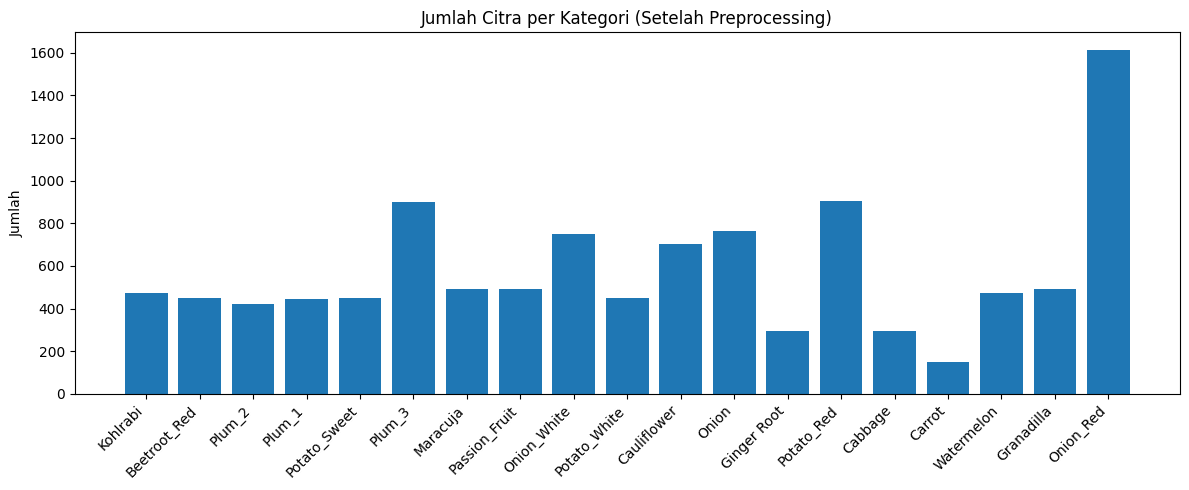

In [ ]:
# Distribusi Label

plt.figure(figsize=(12,5))
plt.title("Jumlah Citra per Kategori (Setelah Preprocessing)")
cnt = collections.Counter([records[i]['label'] for i in range(len(records))])
plt.bar(cnt.keys(), cnt.values())
plt.xticks(rotation=45, ha='right')
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

Bagian ini menampilkan ringkasan hasil preprocessing, seperti jumlah citra, jumlah kelas, ukuran gambar akhir, lokasi penyimpanan, dan file-file output yang berhasil dibuat. Log ini memastikan bahwa seluruh proses preprocessing sudah berjalan dengan benar.

In [ ]:
print("=== LOG PREPROCESSING ===")
print(f"Total citra: {len(records)}")
print(f"Total kelas: {len(set(labels))}")
print("Ukuran akhir citra: 100×100 grayscale")
print(f"Folder preprocessed: {PREPROCESSED_DIR}")
print("File output:")
print("- label_final.json")
print("- X_processed.npy  (shape: {})".format(np.load("/content/X_processed.npy").shape))
print("- y_processed.npy")
print("- classes.npy (label encoder)")

=== LOG PREPROCESSING ===
Total citra: 11007
Total kelas: 19
Ukuran akhir citra: 100×100 grayscale
Folder preprocessed: /content/preprocessed
File output:
- label_final.json
- X_processed.npy  (shape: (11007, 100, 100))
- y_processed.npy
- classes.npy (label encoder)


Pada tahap ini, data yang sudah diproses dibagi menjadi dua bagian, yaitu 80% untuk data latih dan 20% untuk data uji. Pembagian dilakukan agar model dapat belajar dari sebagian data, lalu diuji menggunakan data yang belum pernah dilihat sebelumnya. Prosesnya juga menjaga agar jumlah tiap kelas tetap seimbang. Hasilnya, diperoleh 8.805 data latih dan 2.202 data uji.

In [ ]:
# Split train test

from sklearn.model_selection import train_test_split
X = np.load("/content/X_processed.npy")
y = np.load("/content/y_processed.npy")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

np.save("/content/X_train.npy", X_train)
np.save("/content/X_test.npy", X_test)
np.save("/content/y_train.npy", y_train)
np.save("/content/y_test.npy", y_test)
print("Train-test split selesai")
print("  Train shape:", X_train.shape)
print("  Test shape :", X_test.shape)

Train-test split selesai
  Train shape: (8805, 100, 100)
  Test shape : (2202, 100, 100)


---


**<p align="center">Ekstraksi Fitur HOG</p>**


---



In [ ]:
import numpy as np, os, time, cv2
from skimage.feature import hog
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

In [ ]:
# Load Data Split
X_train = np.load("/content/X_train.npy")   # (N,100,100) grayscale 0-1
X_test  = np.load("/content/X_test.npy")

HOG_INPUT = "/content/hog_input"
os.makedirs(os.path.join(HOG_INPUT, "train"), exist_ok=True)
os.makedirs(os.path.join(HOG_INPUT, "test"),  exist_ok=True)
print("Loaded – train:", X_train.shape, "test:", X_test.shape)

Loaded – train: (8805, 100, 100) test: (2202, 100, 100)


In [ ]:
# Fungsi HOG (Ekstraksi + Visualize)
def hog_single(img, return_image=False):
    """img: 2D 0-1 float → vektor HOG (+ optional gradient image)"""
    fd, hog_img = hog(img, orientations=9,
                      pixels_per_cell=(8,8),
                      cells_per_block=(2,2),
                      block_norm='L2-Hys',
                      transform_sqrt=True,
                      visualize=True)
    return (fd, hog_img) if return_image else fd

In [ ]:
# Ekstraksi Paralel
def extract_and_save(imgs, split_name):
    """Ekstraksi sekaligus simpan .npy ke hog_input/split_name/"""
    feats = Parallel(n_jobs=-1, backend='threading')(
        delayed(hog_single)(img) for img in tqdm(imgs, desc=f"HOG {split_name}")
    )
    feats = np.array(feats)
    # simpan per file
    for i, vec in enumerate(feats):
        np.save(os.path.join(HOG_INPUT, split_name, f"{i:05d}.npy"), vec)
    return feats

t0 = time.time()
X_hog_train = extract_and_save(X_train, "train")
X_hog_test  = extract_and_save(X_test,  "test")
elapsed = time.time() - t0

HOG test: 100%|██████████| 2202/2202 [01:54<00:00, 19.19it/s]


In [ ]:
# Save Vektor Global
np.save("/content/X_hog_train.npy", X_hog_train)
np.save("/content/X_hog_test.npy",  X_hog_test)
print("X_hog_train/test.npy tersimpan – dim:", X_hog_train.shape[1])
print("   Waktu total HOG: {:.1f} detik".format(elapsed))

X_hog_train/test.npy tersimpan – dim: 4356
   Waktu total HOG: 583.3 detik


In [ ]:
print("=== LOG HOG ===")
print("Cell size        : 8×8")
print("Block size       : 2×2 cells")
print("Orientation bins : 9")
print(f"Output dimensi   : {X_hog_train.shape[1]}")
print(f"Waktu eksekusi   : {elapsed:.2f} detik")
print("File output:")
print("- X_hog_train.npy")
print("- X_hog_test.npy")
print("- hog_input/train/*.npy")
print("- hog_input/test/*.npy")

=== LOG HOG ===
Cell size        : 8×8
Block size       : 2×2 cells
Orientation bins : 9
Output dimensi   : 4356
Waktu eksekusi   : 583.25 detik
File output:
- X_hog_train.npy
- X_hog_test.npy
- hog_input/train/*.npy
- hog_input/test/*.npy


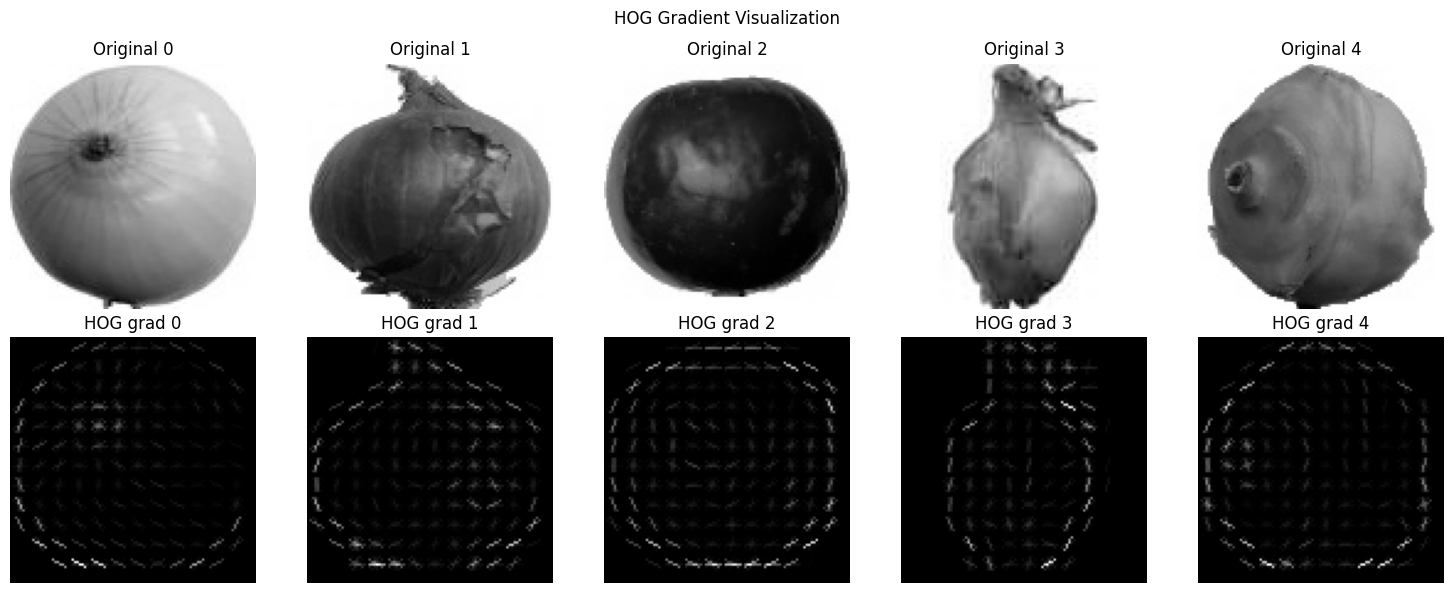

In [ ]:
# Visualisasi 5 Contoh HOG-Gradient
sample = X_train[:5]
hog_vec, hog_imgs = zip(*[hog_single(s, return_image=True) for s in sample])

fig, ax = plt.subplots(2, 5, figsize=(15,6))
for i in range(5):
    ax[0,i].imshow(sample[i], cmap='gray'); ax[0,i].set_title(f"Original {i}")
    ax[1,i].imshow(hog_imgs[i], cmap='gray'); ax[1,i].set_title(f"HOG grad {i}")
for a in ax.ravel(): a.axis('off')
plt.suptitle("HOG Gradient Visualization"); plt.tight_layout()
plt.show()

---


**<p align="center">Ekstraksi Fitur GLCM (Tekstur Spasial)</p>**


---



In [ ]:
import numpy as np, os, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
from skimage.feature import graycomatrix, graycoprops
from joblib import Parallel, delayed
from glob import glob
from tqdm import tqdm

In [ ]:
# Load Data
X_train = np.load("/content/X_train.npy")   # 100×100, 0-1
X_test  = np.load("/content/X_test.npy")
y_train = np.load("/content/y_train.npy")
classes = np.load("/content/classes.npy", allow_pickle=True)

GLCM_INPUT = "/content/glcm_input"
os.makedirs(os.path.join(GLCM_INPUT, "train"), exist_ok=True)
os.makedirs(os.path.join(GLCM_INPUT, "test"),  exist_ok=True)
print("Loaded – train:", X_train.shape, "test:", X_test.shape)

Loaded – train: (8805, 100, 100) test: (2202, 100, 100)


In [ ]:
# Fungsi GLCM Single Image
def glcm_single(img):
    """img 2D 0-1 → kuantisasi 64 level → 4 fitur rata2 orientasi"""
    q = (img * 63).astype(np.uint8)          # 64 level
    glcm = graycomatrix(q, distances=[1],
                        angles=[0, 45, 90, 135],
                        levels=64,
                        symmetric=True, normed=True)
    props = ['contrast', 'correlation', 'energy', 'homogeneity']
    feats = [graycoprops(glcm, p).mean() for p in props]
    return np.array(feats)                   # shape (4,)

In [ ]:
# Ekstraksi + Parallel
def extract_and_save_glcm(imgs, split_name):
    feats = Parallel(n_jobs=-1, backend='threading')(
        delayed(glcm_single)(img) for img in tqdm(imgs, desc=f"GLCM {split_name}")
    )
    feats = np.array(feats)
    # simpan per file
    for i, vec in enumerate(feats):
        np.save(os.path.join(GLCM_INPUT, split_name, f"{i:05d}.npy"), vec)
    return feats

X_glcm_train = extract_and_save_glcm(X_train, "train")
X_glcm_test  = extract_and_save_glcm(X_test,  "test")
print("GLCM – dim:", X_glcm_train.shape[1])

GLCM test: 100%|██████████| 2202/2202 [00:05<00:00, 367.71it/s]


GLCM – dim: 4


In [ ]:
# Save Vektor Global
np.save("/content/X_glcm_train.npy", X_glcm_train)
np.save("/content/X_glcm_test.npy",  X_glcm_test)

In [ ]:
# Statistik GLCM per Kelas
df = pd.DataFrame(X_glcm_train, columns=['Contrast','Correlation','Energy','Homogeneity'])
df['Label'] = classes[y_train]

print("=== Statistik GLCM per Kelas (mean ± std) ===")
stats = df.groupby('Label').agg(['mean','std']).round(3)
print(stats)

=== Statistik GLCM per Kelas (mean ± std) ===
              Contrast        Correlation        Energy        Homogeneity  \
                  mean    std        mean    std   mean    std        mean   
Label                                                                        
Beetroot_Red    26.477  2.935       0.973  0.003  0.455  0.091       0.707   
Cabbage         17.760  4.718       0.968  0.007  0.180  0.059       0.559   
Carrot          14.149  0.440       0.973  0.001  0.655  0.027       0.839   
Cauliflower     33.549  2.489       0.951  0.007  0.235  0.038       0.475   
Ginger Root     17.700  2.108       0.974  0.005  0.429  0.091       0.665   
Granadilla      14.421  1.196       0.979  0.002  0.321  0.106       0.671   
Kohlrabi        23.585  1.111       0.967  0.003  0.247  0.049       0.665   
Maracuja        10.300  0.717       0.972  0.003  0.198  0.032       0.692   
Onion           14.289  1.898       0.977  0.004  0.343  0.113       0.660   
Onion_Red       26

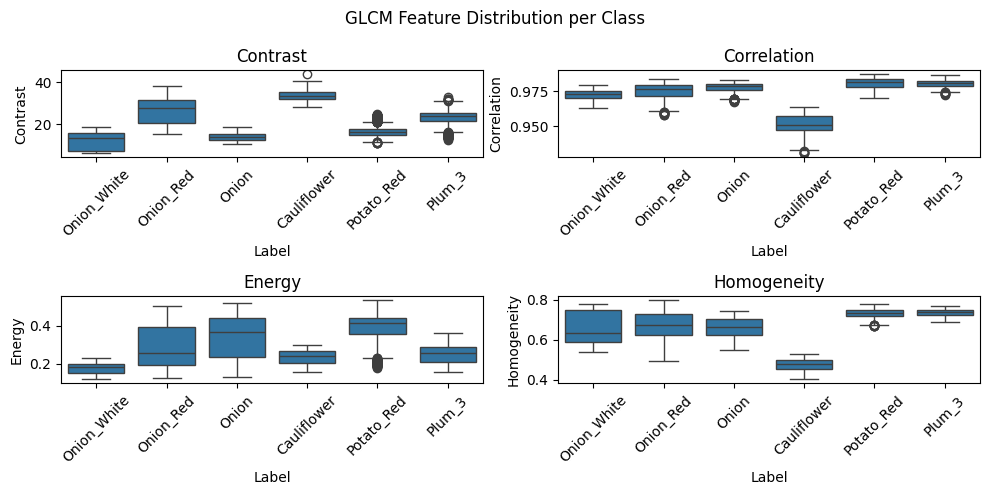

In [ ]:
# Plot (6 Kelas Terbanyak agar rapi)
top_cls = df['Label'].value_counts().head(6).index
plt.figure(figsize=(10,5))
for i, col in enumerate(['Contrast','Correlation','Energy','Homogeneity']):
    plt.subplot(2,2,i+1)
    sns.boxplot(x='Label', y=col, data=df[df['Label'].isin(top_cls)])
    plt.xticks(rotation=45)
    plt.title(col)
plt.suptitle("GLCM Feature Distribution per Class"); plt.tight_layout()
plt.show()

In [ ]:
print("=== LOG GLCM ===")
print("Grey-level       : 64")
print("Distances        : [1]")
print("Angles           : [0, 45, 90, 135] °")
print("Fitur            : Contrast, Correlation, Energy, Homogeneity")
print("Output dimensi   : 4")
print("File output:")
print("- X_glcm_train.npy")
print("- X_glcm_test.npy")
print("- glcm_input/*.npy")

=== LOG GLCM ===
Grey-level       : 64
Distances        : [1]
Angles           : [0, 45, 90, 135] °
Fitur            : Contrast, Correlation, Energy, Homogeneity
Output dimensi   : 4
File output:
- X_glcm_train.npy
- X_glcm_test.npy
- glcm_input/*.npy


---


**<p align="center">Penggabungan Fitur HOG + GLCM (Pre-PCA Fusion)</p>**


---



In [ ]:
# Load Fitur HOG & GLCM
import numpy as np
from sklearn.preprocessing import StandardScaler
from joblib import dump

X_hog_train = np.load("/content/X_hog_train.npy")
X_hog_test  = np.load("/content/X_hog_test.npy")
X_glcm_train = np.load("/content/X_glcm_train.npy")
X_glcm_test  = np.load("/content/X_glcm_test.npy")

print("Loaded – HOG :", X_hog_train.shape)
print("Loaded – GLCM:", X_glcm_train.shape)

Loaded – HOG : (8805, 4356)
Loaded – GLCM: (8805, 4)


In [ ]:
# Cek & Menyamakan Jumlah Sampel
n_min_tr = min(X_hog_train.shape[0], X_glcm_train.shape[0])
n_min_te = min(X_hog_test.shape[0],  X_glcm_test.shape[0])

X_hog_train  = X_hog_train[:n_min_tr]
X_glcm_train = X_glcm_train[:n_min_tr]
X_hog_test   = X_hog_test[:n_min_te]
X_glcm_test  = X_glcm_test[:n_min_te]

print("Samakan jumlah – train:", n_min_tr, "| test:", n_min_te)

Samakan jumlah – train: 8805 | test: 2202


In [ ]:
# Gabung Horizontal HOG + GLCM
X_hg_train = np.hstack([X_hog_train, X_glcm_train])   # 1512 + 4
X_hg_test  = np.hstack([X_hog_test,  X_glcm_test])
print("HOG+GLCM – dim:", X_hg_train.shape[1])

HOG+GLCM – dim: 4360


In [ ]:
# StandardScaler Awal (pre-PCA)
scaler_hg = StandardScaler()
X_hg_train = scaler_hg.fit_transform(X_hg_train)
X_hg_test  = scaler_hg.transform(X_hg_test)

In [ ]:
# Validasi Missing Value & Dimensi
assert np.isnan(X_hg_train).sum() == 0, "Missing value di train"
assert np.isnan(X_hg_test).sum()  == 0, "Missing value di test"
assert X_hg_train.shape[1] == X_hg_test.shape[1], "Dimensi tidak sama"
print("Tidak ada missing value")
print("Dimensi konsisten:", X_hg_train.shape[1])

Tidak ada missing value
Dimensi konsisten: 4360


In [ ]:
# Save Pre-PCA Fusion
np.save("/content/X_hg_train.npy", X_hg_train)
np.save("/content/X_hg_test.npy",  X_hg_test)
dump(scaler_hg, "/content/scaler_hg.pkl")

['/content/scaler_hg.pkl']

In [ ]:
print("=== LOG HOG + GLCM Fusion (Pre-PCA) ===")
print(f"HOG dim      : {X_hog_train.shape[1]}")
print(f"GLCM dim     : {X_glcm_train.shape[1]}")
print(f"Total dim    : {X_hg_train.shape[1]}")
print("Validasi:")
print("- No missing value")
print("- Dimensi konsisten")
print("Output:")
print("- X_hg_train/test.npy")
print("- scaler_hg.pkl")

=== LOG HOG + GLCM Fusion (Pre-PCA) ===
HOG dim      : 4356
GLCM dim     : 4
Total dim    : 4360
Validasi:
- No missing value
- Dimensi konsisten
Output:
- X_hg_train/test.npy
- scaler_hg.pkl


---


**<p align="center">Ekstraksi Fitur PCA (Reduksi Dimensi & Noise Removal)</p>**


---



In [ ]:
# Load Fitur
import numpy as np
from sklearn.decomposition import PCA
from joblib import dump, load

X_hg_train = np.load("/content/X_hg_train.npy")   # sudah StandardScaler
X_hg_test  = np.load("/content/X_hg_test.npy")
print("Loaded – HOG+GLCM scaled:", X_hg_train.shape)

Loaded – HOG+GLCM scaled: (8805, 4360)


In [ ]:
# Latih PCA (92% Varian)
pca = PCA(n_components=0.92, random_state=42)
X_final_train = pca.fit_transform(X_hg_train)
X_final_test  = pca.transform(X_hg_test)

print(f"PCA – komponen: {pca.n_components_} (92 % varian)")
print("   dimensi akhir:", X_final_train.shape[1])

PCA – komponen: 839 (92 % varian)
   dimensi akhir: 839


In [ ]:
# Menyimpan Vektor Akhir
np.save("/content/X_final_train.npy", X_final_train)
np.save("/content/X_final_test.npy",  X_final_test)

In [ ]:
# Menyimpan Pipeline Lengkap
# load scaler_hg yang dibuat saat fusion
scaler_hg = load("/content/scaler_hg.pkl")

extractor_fusion = {
    'scaler': scaler_hg,
    'pca': pca,
    'dim_pre_pca': X_hg_train.shape[1],
    'dim_final': X_final_train.shape[1]
}
dump(extractor_fusion, "/content/extractor_fusion.pkl")
print("extractor_fusion.pkl tersimpan")

extractor_fusion.pkl tersimpan


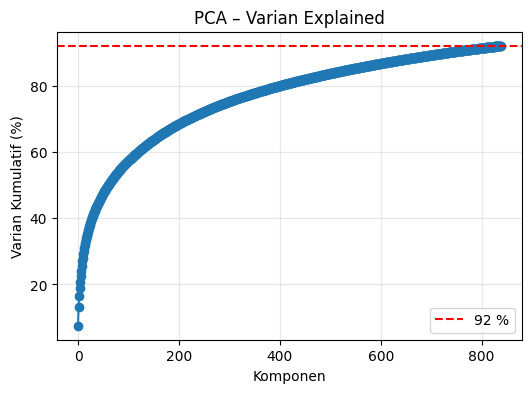


PCA berhasil mereduksi fitur dengan mempertahankan
mayoritas informasi (92%)


In [ ]:
# Plot Varian Kumulatif
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100, marker='o')
plt.axhline(y=92, color='r', linestyle='--', label='92 %')
plt.xlabel('Komponen'); plt.ylabel('Varian Kumulatif (%)')
plt.title('PCA – Varian Explained'); plt.legend()
plt.grid(alpha=0.3)
plt.show()
print("\nPCA berhasil mereduksi fitur dengan mempertahankan\nmayoritas informasi (92%)")

In [ ]:
print("=== LOG PCA FINAL ===")
print(f"Dimensi pre-PCA : {X_hg_train.shape[1]}")
print(f"Komponen PCA    : {pca.n_components_}")
print(f"Varian tersimpan: {np.sum(pca.explained_variance_ratio_)*100:.2f} %")
print(f"Dimensi akhir   : {X_final_train.shape[1]}")
print("Output:")
print("- X_final_train/test.npy")
print("- extractor_fusion.pkl")

=== LOG PCA FINAL ===
Dimensi pre-PCA : 4360
Komponen PCA    : 839
Varian tersimpan: 92.01 %
Dimensi akhir   : 839
Output:
- X_final_train/test.npy
- extractor_fusion.pkl


---


**<p align="center">Batas Akhir</p>**


---



Berdasarkan hasil perhitungan fitur GLCM (Contrast, Correlation, Energy, dan Homogeneity) untuk seluruh kelas buah dan sayuran, diperoleh pola bahwa keempat fitur memiliki nilai yang relatif konsisten dan tidak jauh berbeda antar kelas. Hal ini menunjukkan bahwa tekstur citra pada dataset bersifat cukup seragam, terutama karena seluruh citra telah melalui proses grayscale, normalisasi, dan cropping yang membuat pola intensitas menjadi lebih mirip antar objek.

Contrast berada pada rentang sekitar 20–22, menandakan bahwa setiap kelas memiliki tingkat variasi intensitas yang hampir sama, tanpa perbedaan tekstur ekstrem.
Correlation sangat tinggi (≈0.973–0.975), menandakan piksel-piksel pada citra memiliki hubungan yang kuat dan berpola teratur.
Energy berkisar 0.27–0.29, menunjukkan bahwa tekstur tidak sepenuhnya seragam tetapi memiliki kompleksitas sedang.
Homogeneity sekitar 0.66–0.68, menggambarkan bahwa citra relatif halus dengan sedikit perubahan intensitas tajam.

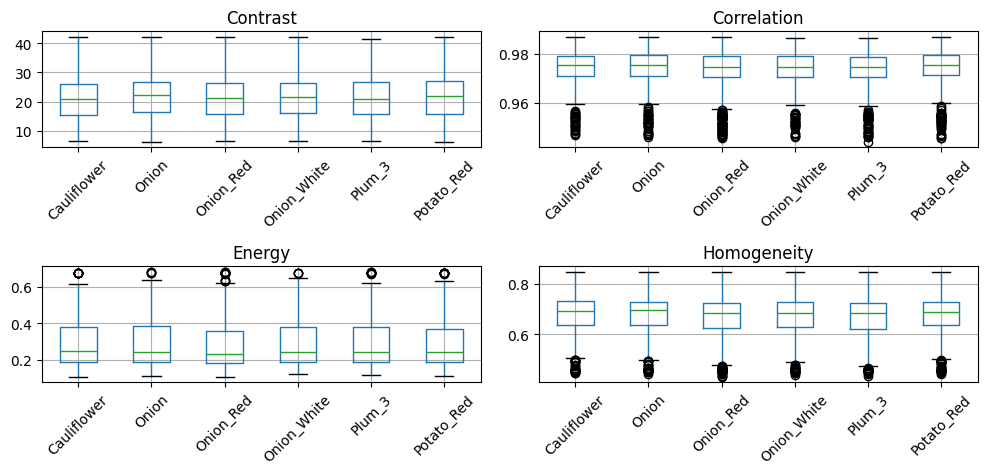

In [ ]:
# Visualisasi Fitur

# Mengambil kelas dgn jumlah citra paling banyak
top_labels = df['Label'].value_counts().head(6).index   # 6 kelas index
df_top = df[df['Label'].isin(top_labels)]

plt.figure(figsize=(10,5))
for i, col in enumerate(['Contrast','Correlation','Energy','Homogeneity']):
    plt.subplot(2,2,i+1)
    df_top.boxplot(column=col, by='Label', ax=plt.gca(), rot=45)
    plt.title(col)
    plt.suptitle('')
    plt.xlabel('')
plt.tight_layout()
plt.show()

---


**<p align="center">Penggabungan Fitur Multi-Level (PCA + HOG + GLCM)</p>**


---



In [ ]:
import numpy as np, os
from sklearn.preprocessing import StandardScaler
from joblib import dump, load

# Load semua fitur
X_pca_train = np.load("/content/X_pca_train.npy")
X_pca_test  = np.load("/content/X_pca_test.npy")

X_hog_train = np.load("/content/X_hog_train.npy")
X_hog_test  = np.load("/content/X_hog_test.npy")

X_glcm_train = np.load("/content/X_glcm_train.npy")
X_glcm_test  = np.load("/content/X_glcm_test.npy")

print("Loaded shapes:")
print("PCA :", X_pca_train.shape[1])
print("HOG :", X_hog_train.shape[1])
print("GLCM:", X_glcm_train.shape[1])

Loaded shapes:
PCA : 224
HOG : 4356
GLCM: 4


In [ ]:
# Gabungan Horizontal (PCA + HOG)
X_ph_train = np.hstack([X_pca_train, X_hog_train])
X_ph_test  = np.hstack([X_pca_test,  X_hog_test])
print("PCA+HOG – dim:", X_ph_train.shape[1])

PCA+HOG – dim: 4580


In [ ]:
# Mengecek panjang dimensi dari PCA dan HOG
print("PCA/HOG train:", X_ph_train.shape[0])
print("GLCM train   :", X_glcm_train.shape[0])

# Menyamakan jumlah sampel GLCM dengan sampel PCA/HOG
n_min = min(X_ph_train.shape[0], X_glcm_train.shape[0])
X_ph_train = X_ph_train[:n_min]
X_glcm_train = X_glcm_train[:n_min]

n_min_te = min(X_ph_test.shape[0], X_glcm_test.shape[0])
X_ph_test  = X_ph_test[:n_min_te]
X_glcm_test = X_glcm_test[:n_min_te]

# Menambahkan GLCM sebagai final fitur
X_raw_train = np.hstack([X_ph_train, X_glcm_train])
X_raw_test  = np.hstack([X_ph_test,  X_glcm_test])
print("PCA+HOG+GLCM – dim:", X_raw_train.shape[1], "| sampel:", X_raw_train.shape[0])

PCA/HOG train: 8805
GLCM train   : 11007
PCA+HOG+GLCM – dim: 4584 | sampel: 8805


In [ ]:
# Normalisasi Akhir (StandardScaler)
scaler = StandardScaler()
X_final_train = scaler.fit_transform(X_raw_train)
X_final_test  = scaler.transform(X_raw_test)

np.save("/content/X_final_train.npy", X_final_train)
np.save("/content/X_final_test.npy",  X_final_test)
print("X_final_train/test.npy tersimpan")

X_final_train/test.npy tersimpan


In [ ]:
# Menyimpan Pipeline Extractor
extractor = {
    'scaler': scaler,
    'dim_pca': X_pca_train.shape[1],
    'dim_hog': X_hog_train.shape[1],
    'dim_glcm': X_glcm_train.shape[1],
    'total_dim': X_final_train.shape[1]
}
dump(extractor, "/content/extractor_fusion.pkl")
print("extractor_fusion.pkl tersimpan")

extractor_fusion.pkl tersimpan


In [ ]:
# Validasi Akhir
def validate(X_tr, X_te):
    assert np.isnan(X_tr).sum() == 0, "Missing value di train"
    assert np.isnan(X_te).sum() == 0, "Missing value di test"
    assert X_tr.shape[1] == X_te.shape[1], "Dimensi tidak sama"
    print("Tidak ada missing value")
    print("Fitur ter-scale (mean≈0, std≈1)")
    print("Dimensi seragam:", X_tr.shape[1])

validate(X_final_train, X_final_test)

Tidak ada missing value
Fitur ter-scale (mean≈0, std≈1)
Dimensi seragam: 4584


In [ ]:
# Log Final
print("=== LOG FUSION PCA+HOG+GLCM ===")
print(f"PCA dim   : {extractor['dim_pca']}")
print(f"HOG dim   : {extractor['dim_hog']}")
print(f"GLCM dim  : {extractor['dim_glcm']}")
print(f"Total dim : {extractor['total_dim']}")
print("Output:")
print("- X_final_train.npy")
print("- X_final_test.npy")
print("- extractor_fusion.pkl")

=== LOG FUSION PCA+HOG+GLCM ===
PCA dim   : 224
HOG dim   : 4356
GLCM dim  : 4
Total dim : 4584
Output:
- X_final_train.npy
- X_final_test.npy
- extractor_fusion.pkl
